In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from uncertainties import ufloat, UFloat

# --- CONFIGURATION ---
TRIGGER_TAG = 'mix' 
FONLL_FACTOR = 0.7878582119

EXTERNAL_ACCEPTANCES = {
    'jpsi_resonant':  ufloat(0.022, 0.00739),
    'psi2s_resonant': ufloat(0.023, 0.00792),
    # 'lowq_resonant': ufloat(..., ...), # Uncomment when ready
}

# Paths
log_dir = '../data/logs'
path_s1 = os.path.join(log_dir, f'cutflow_step1_{TRIGGER_TAG}.csv')
path_s2 = os.path.join(log_dir, f'cutflow_step2_{TRIGGER_TAG}.csv')

# Load Step 1
df1 = pd.read_csv(path_s1)

# Load Step 2
if os.path.exists(path_s2):
    df2 = pd.read_csv(path_s2)
else:
    print("Warning: Step 2 log not found. BDT columns will be 0.")
    df2 = pd.DataFrame(columns=['Sample Name', 'Region', 'SoW_Post_BDT'])

# Merge on Sample Name and Region
df = pd.merge(df1, df2[['Sample Name', 'Region', 'SoW_Post_BDT']], on=['Sample Name', 'Region'], how='left')
df['SoW_Post_BDT'] = df['SoW_Post_BDT'].fillna(0)

# Maps Step 1 output names -> The names expected by the Table Maker logic
col_map = {
    'Before': 'Sow Before Filter',
    'After_Triplet': 'SoW After Triplet Cuts',
    'After_Trigger': 'SoW After Trigger Filter',
    'SumWeights_Trigger': 'SoW Trigger SFs',
    'After_PreselBDT': 'SoW After Preselection BDT Cut',
    'After_AntiD0': 'SoW After Anti-D0 Cuts',
    'After_Q2': 'SoW After q2 Cuts',
    'SoW_Post_BDT': 'SoW After BDT'
}

# Apply renaming
df.rename(columns=col_map, inplace=True)

# Drop technical columns that shouldn't be in the physics table
df.drop(columns=['Trigger_Mode', 'is_data', 'target_trigger'], errors='ignore', inplace=True)

# Set Index
df.set_index('Sample Name', inplace=True)

print("Data Loaded")
display(df.head())

Data Loaded


,Region,Sow Before Filter,SoW After Triplet Cuts,SoW After Trigger Filter,SoW Trigger SFs,SoW After Preselection BDT Cut,SoW After Anti-D0 Cuts,SoW After q2 Cuts,SoW After BDT
Sample Name,,,,,,,,,
jpsi_resonant_test,jpsi,680626.0,498209.0,148552.0,164026.652,164069.236,146974.872,121553.810,83647.488
jpsi_resonant_test,lowq2,680626.0,498209.0,148552.0,164026.652,164069.236,146974.872,800.503,467.808


In [3]:
# Key: Sample Name (Partial match allowed), Value: Raw N_miniaod
raw_miniaod_map = {
    'jpsi_resonant_test':             9345940, 
    'Bu_kaon_jpsi_resonant':          9345940, 
    'Bu_kaon_psi2s_resonant':         1013269, 
    'Bu_kaon_lowq_resonant':          9736873,
    'Bu_kstar_jpsi_kaon_pi0_kaon':    1938219,
    'Bu_kstar_jpsi_ks0_pi_pion':      940945,
    'Bd_k0star_jpsi_kaon_pion_kaon':  947766,
    'Bd_k0star_jpsi_kaon_pion_pion':  947766,
    'Bu_kaon_chic1_jpsi_kaon':        1996426,
    'Bu_jpsi_pi_pion':                1820486,
    'Bu_kstar_psi2s_KS0_pi_pion':     101412,
    'Bd_k0star_psi2s_kaon_pion_kaon': 98229,
    'Bd_k0star_psi2s_kaon_pion_pion': 98229,
    'Bu_kstar_K0S_pi_pion':           940945,
    'Bd_k0star_kaon_pi_kaon':         1055106,
    'Bd_k0star_kaon_pi_pion':         1055106,
}

# Apply FONLL Factor
pre_columns = {k: int(v * FONLL_FACTOR) for k, v in raw_miniaod_map.items()}

# Helper to find the matching key in the Dataframe index
def match_miniaod(row_name):
    for key, val in pre_columns.items():
        if key in row_name: # Simple substring match
            return val
    return np.nan

# Insert N_miniaod at the start
df.insert(0, 'N_miniaod', df.index.map(match_miniaod))

# Ensure columns are ordered logically
cols = ['N_miniaod', 'Sow Before Filter', 'SoW After Triplet Cuts', 'SoW After Trigger Filter', 'SoW Trigger SFs', 'SoW After Preselection BDT Cut', 'SoW After Anti-D0 Cuts', 'SoW After q2 Cuts', 'SoW After BDT']
# Filter to keep only columns that actually exist
cols = [c for c in cols if c in df.columns]
df = df[cols + [c for c in df.columns if c not in cols]] # Append extra columns like 'Region' at end

display(df)

,N_miniaod,Sow Before Filter,SoW After Triplet Cuts,SoW After Trigger Filter,SoW Trigger SFs,SoW After Preselection BDT Cut,SoW After Anti-D0 Cuts,SoW After q2 Cuts,SoW After BDT,Region
Sample Name,,,,,,,,,,
jpsi_resonant_test,7363275,680626.0,498209.0,148552.0,164026.652,164069.236,146974.872,121553.810,83647.488,jpsi
jpsi_resonant_test,7363275,680626.0,498209.0,148552.0,164026.652,164069.236,146974.872,800.503,467.808,lowq2


In [4]:
def format_df(input_df):
    # Create a copy to store the formatted strings
    df_fmt = input_df.copy()
    
    # Define the flow columns
    numeric_cols = ['N_miniaod', 'Sow Before Filter', 'SoW After Triplet Cuts', 
                    'SoW After Trigger Filter', 'SoW After q2 Cuts', 'SoW After BDT']
    
    # Filter for columns that actually exist
    valid_cols = [c for c in numeric_cols if c in df_fmt.columns]
    
    if not valid_cols:
        return df_fmt

    # Format the first column (N_miniaod) as simple integers (no percentage needed)
    first_col = valid_cols[0]
    df_fmt[first_col] = input_df[first_col].fillna(0).astype(int).astype(str)
    
    # Iterate through the rest
    prev_col = first_col
    
    for col in valid_cols[1:]:
        # CRITICAL FIX: Read numbers from 'input_df' (original), NOT 'df_fmt' (modified strings)
        prev_values = input_df[prev_col].fillna(0)
        cur_values = input_df[col].fillna(0)
        
        formatted_list = []
        for c, p in zip(cur_values, prev_values):
            if p > 0:
                perc = (c / p) * 100
                formatted_list.append(f"{int(c)} ({perc:.1f}%)")
            else:
                formatted_list.append(f"{int(c)} (nan%)")
        
        # Write the formatted string to the copy
        df_fmt[col] = formatted_list
        
        # Update pointer for logical flow, but read data from input_df next time
        prev_col = col 
        
    return df_fmt

# Display helper
def group_and_display(df_to_show):
    # Groups based on index string matching
    substrings_groups = [
        ("J/ψ Control Region", ["jpsi"]),
        ("ψ(2S) Control Region", ["psi2s"]),
        ("Low-q² Signal Region", ["lowq2", "lowq"])
    ]
    
    df_display = df_to_show.copy()
    df_display["group"] = "Other"

    # Assign groups
    for label, substrings in substrings_groups:
        mask = df_display.index.to_series().str.contains("|".join(substrings), case=False)
        df_display.loc[mask, "group"] = label

    # Render tables
    for group_label, group_df in df_display.groupby("group"):
        if group_label == "Other" and group_df.empty: continue
        
        # Sort so Resonant appears first (optional)
        group_df = group_df.sort_index() 
        
        display(
            group_df.drop(columns=["group", "Region"], errors='ignore')
            .style.set_caption(group_label)
            .set_table_styles([{
                'selector': 'caption',
                'props': [('font-size', '125%'), ('font-weight', 'bold')]
            }])
        )

# Run it
formatted_view = format_df(df)
group_and_display(formatted_view)

,N_miniaod,Sow Before Filter,SoW After Triplet Cuts,SoW After Trigger Filter,SoW Trigger SFs,SoW After Preselection BDT Cut,SoW After Anti-D0 Cuts,SoW After q2 Cuts,SoW After BDT
Sample Name,,,,,,,,,
jpsi_resonant_test,7363275,680626 (9.2%),498209 (73.2%),148552 (29.8%),164026.652000,164069.236000,146974.872000,121553 (81.8%),83647 (68.8%)
jpsi_resonant_test,7363275,680626 (9.2%),498209 (73.2%),148552 (29.8%),164026.652000,164069.236000,146974.872000,800 (0.5%),467 (58.4%)


In [5]:
def format_eff_df(input_df, acceptance_dict=None):
    # Create a copy to store the output
    df_eff = input_df.copy()
    
    # --- 1. INJECT DETECTOR ACCEPTANCE (Step 0) ---
    if acceptance_dict:
        # Create empty column with object dtype (crucial for ufloats)
        df_eff.insert(0, 'α Detector', np.nan)
        df_eff['α Detector'] = df_eff['α Detector'].astype(object)
        
        # Populate based on substring matches
        for substring, val in acceptance_dict.items():
            mask = df_eff.index.str.contains(substring, case=False, na=False)
            df_eff.loc[mask, 'α Detector'] = val

    # --- 2. DEFINE COLUMN ORDER ---
    numeric_cols = [
        'α Detector', 
        'N_miniaod', 
        'Sow Before Filter', 
        'SoW After Triplet Cuts', 
        'SoW After Trigger Filter', 
        'SoW Trigger SFs', 
        'SoW After Preselection BDT Cut', 
        'SoW After Anti-D0 Cuts', 
        'SoW After q2 Cuts', 
        'SoW After BDT'
    ]
    
    valid_cols = [c for c in numeric_cols if c in df_eff.columns]
    if len(valid_cols) < 2: return df_eff

    # --- 3. CALCULATE STEP-BY-STEP EFFICIENCY ---
    start_col = valid_cols[0]
    prev_col_name = start_col
    
    for col_name in valid_cols[1:]:
        # Read from input_df (Raw) if possible
        if prev_col_name in input_df.columns:
            prev_values = input_df[prev_col_name]
        else:
            prev_values = df_eff[prev_col_name]
            
        if col_name in input_df.columns:
            cur_values = input_df[col_name]
        else:
            cur_values = df_eff[col_name]
        
        new_col_data = []
        for c, p in zip(cur_values, prev_values):
            c_val = c.n if hasattr(c, 'n') else c
            p_val = p.n if hasattr(p, 'n') else p
            
            if pd.isna(c_val) or pd.isna(p_val) or p_val == 0:
                new_col_data.append(np.nan)
            else:
                val = c_val / p_val
                err = np.sqrt(c_val) / p_val if c_val > 0 else 0
                new_col_data.append(ufloat(val, err))
                
        df_eff[col_name] = new_col_data
        prev_col_name = col_name

    # --- 4. CALCULATE TOTAL ACCEPTANCE x EFFICIENCY ---
    total_acc_eff = []
    n_gen_col = 'N_miniaod'
    final_col = valid_cols[-1] 
    
    # Use enumerate to track integer position (i) for safe lookups
    for i, (idx, row) in enumerate(input_df.iterrows()):
        try:
            # Base Efficiency: Final / N_Gen
            n_gen = row[n_gen_col]
            n_final = row[final_col] 
            
            if n_gen > 0:
                base_eff = n_final / n_gen
                base_err = np.sqrt(n_final) / n_gen if n_final > 0 else 0
                total = ufloat(base_eff, base_err)
            else:
                total = np.nan
            
            # Multiply by Detector Acceptance if it exists
            if acceptance_dict and 'α Detector' in df_eff.columns:
                # FIX: Use .iloc[i] to get the scalar for THIS specific row safely
                alpha = df_eff['α Detector'].iloc[i]
                
                # Check for ufloat or non-NaN value
                if hasattr(alpha, 'n') or pd.notna(alpha):
                    if hasattr(total, 'n'): # Ensure total is also valid
                        total = total * alpha
            
            total_acc_eff.append(total)
            
        except KeyError:
            total_acc_eff.append(np.nan)

    df_eff['Total acc. x eff.'] = total_acc_eff
    df_eff.drop(columns=['N_miniaod'], errors='ignore', inplace=True)
    
    return df_eff

# --- EXECUTE ---
df_effs = format_eff_df(df, EXTERNAL_ACCEPTANCES)

# Rename columns
rename_dict = {
    'Sow Before Filter': 'ε NanoAOD',
    'SoW After Triplet Cuts': 'ε Triplet',
    'SoW After Trigger Filter': 'ε Trigger',
    'SoW Trigger SFs': 'ε Trigger SFs',
    'SoW After Preselection BDT Cut': 'ε Presel BDT',
    'SoW After Anti-D0 Cuts': 'ε Anti-D0',
    'SoW After q2 Cuts': 'ε q2 Cuts',
    'SoW After BDT': 'ε BDT'
}
df_effs.rename(columns=rename_dict, inplace=True)

display(df_effs.head())

,α Detector,ε NanoAOD,ε Triplet,ε Trigger,ε Trigger SFs,ε Presel BDT,ε Anti-D0,ε q2 Cuts,ε BDT,Region,Total acc. x eff.
Sample Name,,,,,,,,,,,
jpsi_resonant_test,0.022+/-0.007,0.09244+/-0.00011,0.7320+/-0.0010,0.2982+/-0.0008,1.1042+/-0.0027,1.0003+/-0.0025,0.8958+/-0.0023,0.8270+/-0.0024,0.6882+/-0.0024,jpsi,0.00025+/-0.00008
jpsi_resonant_test,0.022+/-0.007,0.09244+/-0.00011,0.7320+/-0.0010,0.2982+/-0.0008,1.1042+/-0.0027,1.0003+/-0.0025,0.8958+/-0.0023,0.00545+/-0.00019,0.584+/-0.027,lowq2,(1.4+/-0.5)e-06


In [6]:
def make_axe_table(df_input, title="Acceptance x Efficiency"):
    # 1. Work on a flat copy to avoid "Duplicate Index" issues
    df_flat = df_input.reset_index() 
    
    # 2. Define the exact targets we want in the table
    # Format: (Substring in Name, Substring in Region, Output Column Name)
    targets = [
        ('jpsi_resonant', 'jpsi', 'B⁺ → K⁺ J/ψ(→ e⁺e⁻)'),
        ('psi2s_resonant', 'psi2s', 'B⁺ → K⁺ ψ(2S)(→ e⁺e⁻)'),
        ('lowq_resonant', 'lowq',  'B⁺ → K⁺e⁺e⁻ (Low-q²)')
    ]
    
    selected_rows = []
    
    for name_sub, region_sub, nice_name in targets:
        # Create boolean masks
        # Mask 1: Does the Sample Name contain the substring? (e.g. "jpsi_resonant")
        name_mask = df_flat['Sample Name'].str.contains(name_sub, case=False, na=False)
        
        # Mask 2: Does the Region contain the substring? (e.g. "jpsi")
        # We assume the column exists; if not, we skip region filtering
        if 'Region' in df_flat.columns:
            region_mask = df_flat['Region'].astype(str).str.contains(region_sub, case=False, na=False)
            final_mask = name_mask & region_mask
        else:
            final_mask = name_mask

        # Apply mask
        matches = df_flat[final_mask]
        
        if matches.empty:
            continue
            
        # Select the FIRST match found (solves the duplication issue)
        # We copy it to avoid setting-with-copy warnings later
        row = matches.iloc[0].copy()
        
        # Rename the Series name so it becomes the column header later
        row.name = nice_name 
        selected_rows.append(row)

    if not selected_rows:
        print("No matching rows found for table.")
        return

    # 3. Construct the Table
    # Convert list of Series -> DataFrame
    table_df = pd.DataFrame(selected_rows)
    
    # Drop technical columns we don't want to display
    table_df.drop(columns=['Sample Name', 'Region', 'index'], errors='ignore', inplace=True)
    
    # Transpose so Steps are Rows and Samples are Columns
    table_df = table_df.T
    
    # 4. Formatting
    def fmt(x):
        if hasattr(x, 'n'): # Check if ufloat
            # Scientific notation for tiny numbers (Total Acc x Eff)
            if abs(x.n) < 0.01: return f"{x.n:.2e} ± {x.s:.1e}"
            # Standard decimal for ratios
            return f"{x.n:.3f} ± {x.s:.3f}"
        elif pd.isna(x): 
            return "-"
        return str(x)

    # 5. Display
    display(
        table_df.style
        .set_caption(title)
        .format(fmt)
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '110%')]},
            {'selector': 'caption', 'props': [('font-size', '150%'), ('font-weight', 'bold'), ('padding', '10px')]}
        ])
    )

# --- RUN IT ---
make_axe_table(df_effs, title=f"Final Efficiency Table ({TRIGGER_TAG})")

,B⁺ → K⁺ J/ψ(→ e⁺e⁻)
α Detector,0.022 ± 0.007
ε NanoAOD,0.092 ± 0.000
ε Triplet,0.732 ± 0.001
ε Trigger,0.298 ± 0.001
ε Trigger SFs,1.104 ± 0.003
ε Presel BDT,1.000 ± 0.002
ε Anti-D0,0.896 ± 0.002
ε q2 Cuts,0.827 ± 0.002
ε BDT,0.688 ± 0.002
Total acc. x eff.,2.50e-04 ± 8.4e-05


Plotting cutflow for: jpsi_resonant_test


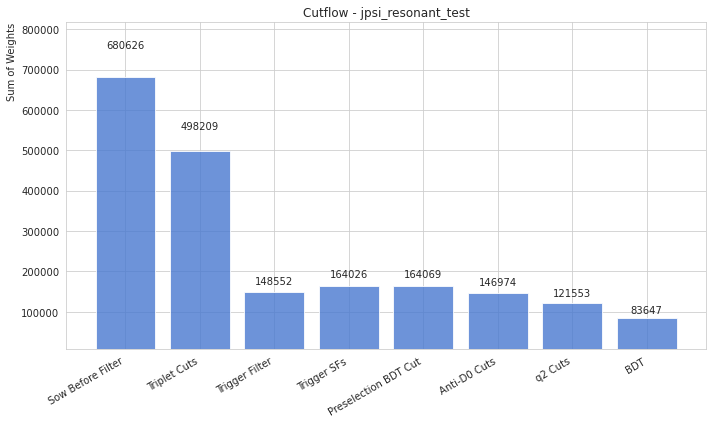

In [23]:
def plot_cutflow(df, row_name):
    if row_name not in df.index:
        print(f"Sample {row_name} not found.")
        return

    # Columns to plot (Ordered logic)
    plot_cols = [
        'Sow Before Filter', 
        'SoW After Triplet Cuts', 
        'SoW After Trigger Filter', 
        'SoW Trigger SFs', 
        'SoW After Preselection BDT Cut', 
        'SoW After Anti-D0 Cuts',
        'SoW After q2 Cuts', 
        'SoW After BDT'
    ]
    # Filter to keep only columns that actually exist in the dataframe
    plot_cols = [c for c in plot_cols if c in df.columns]
    
    # --- HANDLE DUPLICATES ---
    row = df.loc[row_name]
    if isinstance(row, pd.DataFrame):
        print(f"Warning: Multiple entries found for '{row_name}'. Using the first one.")
        # Select the first occurrence and squeeze it to a Series
        row = row.iloc[0]
        
    # Extract values as a flattened 1D array of floats
    counts = row[plot_cols].values.astype(float)
    
    # --- PLOT ---
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    x = np.arange(len(plot_cols))
    
    # Plot bars
    ax.bar(x, counts, alpha=0.8, color=sns.color_palette("muted")[0])
    
    # Add labels above bars
    for xi, yi in zip(x, counts):
        if yi > 0: # Avoid log(0) issues visually
            ax.text(xi, yi * 1.1, f"{int(yi)}", ha='center', va='bottom', fontsize=10)
        
    ax.set_xticks(x)
    # Wrap long labels for readability
    labels = [c.replace('SoW ', '').replace('After ', '') for c in plot_cols]
    ax.set_xticklabels(labels, rotation=30, ha='right')
    
    # Log scale is usually best for cutflows
    # ax.set_yscale('log')

    # Set y-limit to make room for text labels
    ax.set_ylim(bottom=min(counts)*.1, top=max(counts)*1.2)
    
    ax.set_ylabel('Sum of Weights', loc='top')
    ax.set_title(f'Cutflow - {row_name}')
    plt.tight_layout()
    plt.show()

# Example Usage: Plot the first resonant sample found
# We search for "resonant" in the index to find a valid sample name
resonant_samples = [s for s in df.index if 'resonant' in s]
if resonant_samples:
    # Use the first match found
    target_sample = resonant_samples[0]
    print(f"Plotting cutflow for: {target_sample}")
    plot_cutflow(df, target_sample)
else:
    print("No 'resonant' samples found in dataframe index.")